## Predictive Approach for Failure Detection in Electrical Submersible Pump Systems

The oil and gas industry has always been challenged to identify any electrical submersible pump (ESP) abnormal performance to avoid ESP failure. Given the high cost of ESP maintenance, there is always a demand for real-time failure detection systems which are applied to monitor ESP performance and identify failure events before they happen. 
In this notebook, we'll try to build a machine learning model that is able to predict ESP failure in oil wells before it happens based on historical daily data of multiple wells and pumps. 

#### Importing librairies & packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import visualkeras
plt.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,RobustScaler
from keras.utils import np_utils
import seaborn as sns
import plotly.express as px
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding, LSTM, SpatialDropout1D, RepeatVector, TimeDistributed, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D
from tensorflow.keras import layers

#### Loading Data

We first load and get a general overview of the data we have. 

In [2]:
data = pd.read_csv("wells_data.csv", parse_dates=True, index_col="Unnamed: 0")
print("> Dataset have",data.shape[0],"rows and",data.shape[1],"columns/features.")
print("> These are the features present in the dataset :", data.keys().to_list())

> Dataset have 58979 rows and 25 columns/features.
> These are the features present in the dataset : ['DATE', 'WELL_ID', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'OUT_VOLT', 'VIBRATION', 'BFPD', 'BOPD', 'BWPD', 'MSCF', 'BSW', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'API', 'FREC(Hz)', 'PIP(PSI)', 'INTAKE_DEPTH', 'AMPERAGE', 'PUMP', 'WHP(PSI)', 'FAILURE']


The dataset is separated into 23 columns related to the well variables, 'FAILURE' column is the target describing the pump status, and a 'DATE' column for timestamp. We can see also that the data is recorded daily.

In [3]:
data.head()

,DATE,WELL_ID,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,...,GOR(MSFC/BPPD),GLR(SCF/BFPD),API,FREC(Hz),PIP(PSI),INTAKE_DEPTH,AMPERAGE,PUMP,WHP(PSI),FAILURE
0,2019-02-25,DEEPWATER-000XAR,72.42,4252.87,57.44,1443.97,222.71,281.56,0.0,0.17,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
1,2019-02-26,DEEPWATER-000XAR,72.77,4203.62,57.44,1414.84,222.80,281.09,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
2,2019-02-27,DEEPWATER-000XAR,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
3,2019-02-28,DEEPWATER-000XAR,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0
4,2019-03-01,DEEPWATER-000XAR,72.29,4271.55,57.45,1449.17,222.72,281.55,0.0,0.15,...,123.54874,6.177437,18.6,57.5,1453.0,8915.0,72.0,ESP-890,330.0,0


In [4]:
data.describe()

,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,BFPD,BOPD,...,BSW,GOR(MSFC/BPPD),GLR(SCF/BFPD),API,FREC(Hz),PIP(PSI),INTAKE_DEPTH,AMPERAGE,WHP(PSI),FAILURE
count,58979.000000,57194.000000,58979.000000,58979.000000,58503.000000,58168.000000,27726.000000,56666.000000,58979.000000,58979.000000,...,58979.000000,58979.000000,58979.000000,58979.000000,58979.000000,58075.000000,58979.000000,58979.000000,58979.000000,58979.000000
mean,34.894016,3162.037101,59.276908,674.075516,228.011368,266.758217,264.853927,0.294852,696.869941,310.084317,...,39.730874,97.704274,60.011508,22.250739,61.604775,494.972312,9611.645366,36.663072,113.594751,0.002119
std,16.541065,1734.936712,24.792601,979.063617,41.387009,51.829133,208.575610,1.811388,637.861865,302.520470,...,31.568172,64.896288,56.206490,5.714801,17.699490,417.350432,514.492850,16.583678,75.641891,0.052850
min,20.000000,0.000000,25.000000,0.000000,175.000000,175.000000,0.000000,0.000000,13.900000,7.300000,...,0.000000,0.000000,0.000000,10.000000,25.000000,0.000000,8000.000000,20.000000,0.500000,0.000000
25%,21.000000,3073.074835,52.000000,240.000000,223.439753,247.100000,0.000000,0.000000,220.000000,138.000000,...,5.000000,55.991627,16.801999,18.000000,54.000000,262.000000,9392.000000,23.000000,50.000000,0.000000
50%,29.000000,3817.672946,56.000000,344.240000,229.140000,278.000000,394.408846,0.000000,456.000000,231.400000,...,38.000000,84.003411,42.560000,19.200000,57.000000,356.000000,9589.000000,31.000000,100.000000,0.000000
75%,44.607595,4056.821263,61.000000,668.973873,235.596872,294.840000,446.305000,0.222373,1020.000000,390.060000,...,70.000000,145.814707,82.331081,27.100000,63.000000,561.000000,9899.000000,48.000000,150.000000,0.000000
max,150.000000,10500.000000,150.000000,5000.000000,500.000000,500.000000,607.540000,20.000000,3866.000000,2425.840000,...,99.000000,300.000000,300.000000,42.000000,150.000000,5000.000000,11850.000000,150.000000,400.000000,2.000000


Let's check the type of values we have in each column. We have 3 categorical variables : DATE, WELL_ID, and PUMP. The remaining features are typed as float, and target's values are integers.

In [5]:
print(dict(data.dtypes))

{'DATE': dtype('O'), 'WELL_ID': dtype('O'), 'CURRENT': dtype('float64'), 'PRESS_DESC': dtype('float64'), 'FREQUENCY': dtype('float64'), 'PRESS_INT': dtype('float64'), 'TEMP_INT': dtype('float64'), 'TEMP_MOT': dtype('float64'), 'OUT_VOLT': dtype('float64'), 'VIBRATION': dtype('float64'), 'BFPD': dtype('float64'), 'BOPD': dtype('float64'), 'BWPD': dtype('float64'), 'MSCF': dtype('float64'), 'BSW': dtype('float64'), 'GOR(MSFC/BPPD)': dtype('float64'), 'GLR(SCF/BFPD)': dtype('float64'), 'API': dtype('float64'), 'FREC(Hz)': dtype('float64'), 'PIP(PSI)': dtype('float64'), 'INTAKE_DEPTH': dtype('float64'), 'AMPERAGE': dtype('float64'), 'PUMP': dtype('O'), 'WHP(PSI)': dtype('float64'), 'FAILURE': dtype('int64')}


> #### Feature Description    

High Frequency Data
- CURRENT(Amperes)
- PRESS_DESC: Discharge Pressure (Psi)
- FREQUENCY(Hz)
- PRES_INT: Intake Pressure (Psi)
- TEMP_INT: Intake Temperature (°F)
- TEMP_MOT: Engine temperature (°F)
- OUT_VOLT: Output Voltage (V)
- PRES_INTK: Intake Pressure (Psi)
- TEMP_INTK: Intake Temperature (°F)
- Vibration: 
	Normal Range Values lie between 0 - 0.8
	Sensor shows alerts when tren is up
	Values over 10 could mean wrong information (noise) or damage in the pumps
	Outliers in the readings mean piezoelectric is damaged
	
Production Data
- BFPD: Barrels of Fluid per Day	
- BOPD: Barrels of Oil per Day	
- BWPD: Barrels of Water per Day
- MSCF: Million of Standard Cubic Feet
- BSW: Basic sediment and water (%)
- GOR(MSFC/BPPD): Gas-oil Relation
- GLR(SCF/BFPD): Gas-liquid Relation
- API: Oil API Gravity
- FREC(Hz): Frequency	
- PIP(PSI):  Pump intake pressure
- PROF_INTAKE(ft): Intake Depth 
- AMPERAGE: Current
- PUMP: Pump name
- PSI_CAB: Wellhead Pressure


Now, let's take a closer look at the target values. 
* We have 3 classes : 0 for normal pump, 1 for failure, 2 for manual-off.
* Our dataset is highly-imbalanced.
* The class 0 for 'normal' is present in most of the rows.

In [6]:
data.FAILURE.value_counts()

0    58874
1       85
2       20
Name: FAILURE, dtype: int64

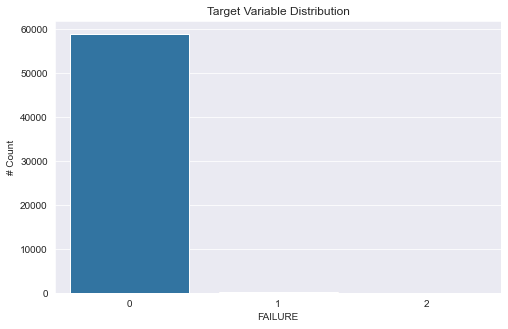

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(data["FAILURE"])
plt.title('Target Variable Distribution')
plt.ylabel('# Count')
plt.show()

Let's look for missing values in our dataset. We have columns with missing values, but the target variable doesn't have any missing value.

In [8]:
data.isna().sum()

DATE                  0
WELL_ID               0
CURRENT               0
PRESS_DESC         1785
FREQUENCY             0
PRESS_INT             0
TEMP_INT            476
TEMP_MOT            811
OUT_VOLT          31253
VIBRATION          2313
BFPD                  0
BOPD                  0
BWPD                  0
MSCF                  0
BSW                   0
GOR(MSFC/BPPD)        0
GLR(SCF/BFPD)         0
API                   0
FREC(Hz)              0
PIP(PSI)            904
INTAKE_DEPTH          0
AMPERAGE              0
PUMP                  0
WHP(PSI)              0
FAILURE               0
dtype: int64

#### Cleaning & Preparing Data

**Transforming Date**

In [9]:
data['DATE'] = pd.to_datetime(data['DATE'], infer_datetime_format=True)
data = data.set_index('DATE')

**Imputing missing values**

In [10]:
data.fillna(method='bfill', inplace=True)
assert data.isna().sum().sum() == 0

**Encoding Categorical Features**

In [11]:
# Ordinal Encoding for WELL_ID feature
nums = np.arange(1,len(data['WELL_ID'].unique())+1)
data_dict = dict(zip(data['WELL_ID'].unique(),nums))
data['WELL_ID'] = data['WELL_ID'].replace(data_dict)
# Ordinal Encoding for PUMP feature
pump_names = data['PUMP'].str.split(pat='-', n=1, expand=True)
data['PUMP'] = pump_names[1]
data['PUMP'] = data['PUMP'].astype(int)


**Visualizing Data**

array([[<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>],
       [<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
        <AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>]],
      dtype=object)

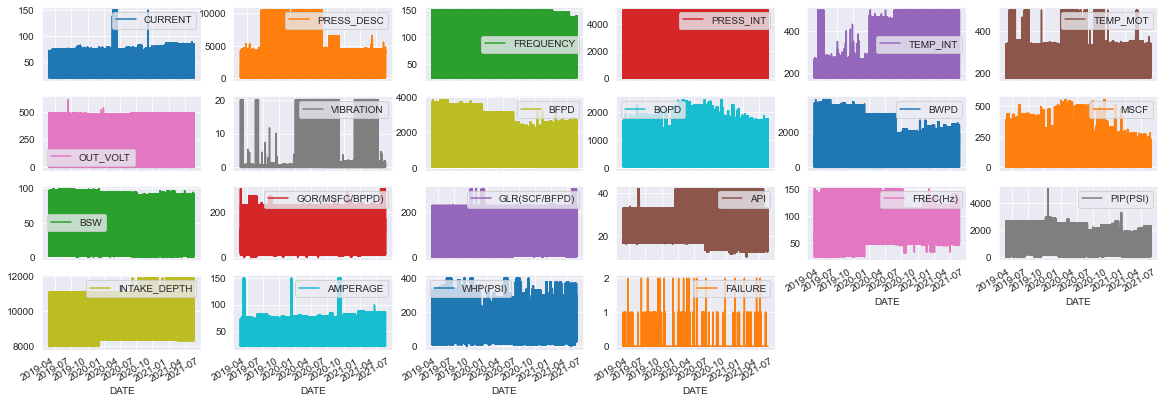

In [12]:
data[['CURRENT','PRESS_DESC', 'FREQUENCY', 'PRESS_INT','TEMP_INT', 'TEMP_MOT', 'OUT_VOLT', 'VIBRATION', 'BFPD', 'BOPD', 'BWPD','MSCF', 'BSW', 'GOR(MSFC/BPPD)', 'GLR(SCF/BFPD)', 'API', 'FREC(Hz)',
       'PIP(PSI)', 'INTAKE_DEPTH', 'AMPERAGE', 'WHP(PSI)', 'FAILURE']].plot(subplots=True,figsize=(20, 7), layout=(4,6))

**Handling Imbalanced Target**

In [13]:
data['FAILURE'].replace(2,1, inplace=True)
failure_resampling=pd.DataFrame()
for i in range(1, 100):
    failure_resampling=pd.concat([failure_resampling, data[data["FAILURE"]==1]], axis=0)

data=pd.concat([data[data["FAILURE"]==0],failure_resampling], axis=0)
data=data.sort_values(["WELL_ID","DATE"])

data['FAILURE'].value_counts()

0    58874
1    10395
Name: FAILURE, dtype: int64

**Selecting Features & Splitting Data**

In [14]:
well_data = data #.sort_index(ascending=True)
#features = list(well_data.keys().drop(['FAILURE','PUMP','PIP(PSI)','AMPERAGE', 'FREC(Hz)','WHP(PSI)','MSCF','BFPD'])) #,'MSCF','BFPD', 'PUMP'

features = ['WELL_ID','CURRENT','PRESS_DESC','FREQUENCY','PRESS_INT','TEMP_INT','TEMP_MOT','VIBRATION', 'INTAKE_DEPTH']

target = 'FAILURE'
print("> We'll use these features for training :", features)

X = well_data[features].copy()
y = well_data[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False)


> We'll use these features for training : ['WELL_ID', 'CURRENT', 'PRESS_DESC', 'FREQUENCY', 'PRESS_INT', 'TEMP_INT', 'TEMP_MOT', 'VIBRATION', 'INTAKE_DEPTH']


**Scaling and Normalizing**

In [15]:
# Scaling numerical features, we don't want the WELL_ID to be scaled 
scalable_features = X.columns.to_list()
scalable_features.remove('WELL_ID')
cat_features = ['WELL_ID']

min_max_scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(min_max_scaler.fit_transform(X_train[scalable_features]), columns=scalable_features)
X_test_scaled = pd.DataFrame(min_max_scaler.transform(X_test[scalable_features]), columns=scalable_features)

X_train_scaled.index = X_train.index
X_test_scaled.index = X_test.index

cat_X_train = X_train.drop(scalable_features, axis=1)
cat_X_test = X_test.drop(scalable_features, axis=1)

**Reducing Dataset Dimensionality with PCA**

Principal Component Analysis (PCA) is used to reduce the number of variables of the dataset, while preserving as much information as possible.

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
columns = ['pca_%i' % i for i in range(4)]
X_train_scaled = pd.DataFrame(pca.fit_transform(X_train_scaled), columns=columns, index=X_train_scaled.index)
X_test_scaled = pd.DataFrame(pca.transform(X_test_scaled), columns=columns, index=X_test_scaled.index)

In [17]:
X_train_well = pd.concat([cat_X_train, X_train_scaled], axis=1)
X_test_well = pd.concat([cat_X_test, X_test_scaled], axis=1)

X_train = pd.concat([cat_X_train, X_train_scaled], axis=1).drop(columns=['WELL_ID'])
X_test = pd.concat([cat_X_test, X_test_scaled], axis=1).drop(columns=['WELL_ID'])

In [18]:
print("Training", X_train.shape, y_train.shape)
print("Test",X_test.shape, y_test.shape)

Training (48488, 4) (48488,)
Test (20781, 4) (20781,)


**Generating Time Sequences**

In [19]:
from keras.preprocessing.sequence import TimeseriesGenerator
window = 20 
batch_size = 200
num_features = 4
s = 1
r = 1
train_generator = TimeseriesGenerator(X_train.to_numpy(), y_train, length=window, stride=s, sampling_rate=r, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test.to_numpy(), y_test, length=window, stride=s, sampling_rate=r, batch_size=batch_size)

from sklearn.utils.class_weight import compute_class_weight  
class_weights = dict(zip(well_data['FAILURE'].unique(), compute_class_weight(class_weight = "balanced", classes = well_data['FAILURE'].unique(), y=well_data['FAILURE'].values)))


#### Modeling & Evaluation

**Training LSTM Model**

In [20]:
model = Sequential()
reg = tf.keras.regularizers.L2(0.005)
model.add(LSTM(100,dropout=0.15, activation="tanh", input_shape=(window, num_features), return_sequences = True, kernel_regularizer=reg))
model.add(LSTM(50,dropout=0.15,  activation="tanh", return_sequences=False, kernel_regularizer=reg))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=reg))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(train_generator, epochs=100, validation_data=test_generator, shuffle=False, class_weight=class_weights)

Epoch 1/100
243/243 [==============================] - 7s 15ms/step - loss: 0.8355 - accuracy: 0.6372 - val_loss: 0.6355 - val_accuracy: 0.7256
Epoch 2/100
243/243 [==============================] - 3s 12ms/step - loss: 0.6917 - accuracy: 0.6322 - val_loss: 0.7079 - val_accuracy: 0.6744
Epoch 3/100
243/243 [==============================] - 3s 11ms/step - loss: 0.6670 - accuracy: 0.6661 - val_loss: 0.6864 - val_accuracy: 0.6698
Epoch 4/100
243/243 [==============================] - 3s 12ms/step - loss: 0.6544 - accuracy: 0.6657 - val_loss: 0.6622 - val_accuracy: 0.6623
Epoch 5/100
243/243 [==============================] - 3s 12ms/step - loss: 0.6507 - accuracy: 0.6545 - val_loss: 0.6599 - val_accuracy: 0.6582
Epoch 6/100
243/243 [==============================] - 3s 11ms/step - loss: 0.6475 - accuracy: 0.6504 - val_loss: 0.6576 - val_accuracy: 0.6586
Epoch 7/100
243/243 [==============================] - 3s 11ms/step - loss: 0.6456 - accuracy: 0.6488 - val_loss: 0.6594 - val_accuracy:

In [22]:
# Training Accuracy & Loss
scores = model.evaluate(train_generator)
print(f'Training Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
# Test Accuracy & Loss
scores = model.evaluate(test_generator)
print(f'Test Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

243/243 [==============================] - 1s 5ms/step - loss: 0.5809 - accuracy: 0.7403
Training Score: loss of 0.5809286236763; accuracy of 74.03441667556763%
104/104 [==============================] - 1s 5ms/step - loss: 0.6042 - accuracy: 0.7210
Test Score: loss of 0.6041828989982605; accuracy of 72.10153937339783%


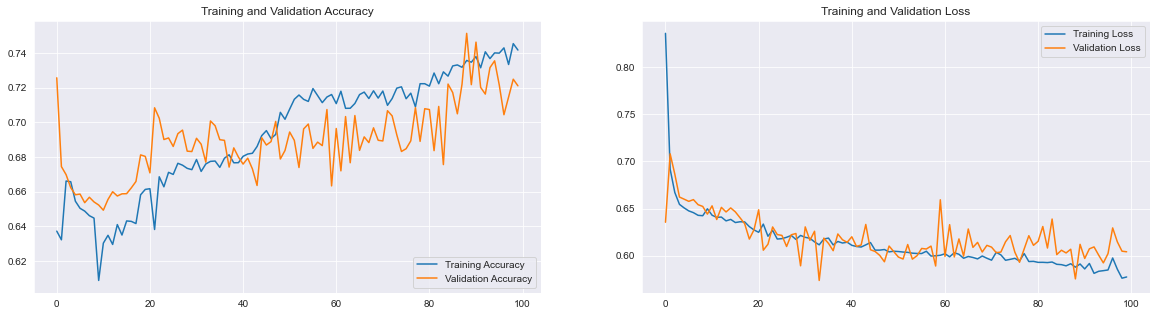

In [23]:
def plot_eval(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(100)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_eval(history)

**Predict Pump Failure in Well**

In [24]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix


def get_well_data(well_id): 
    dd = pd.concat([X_test_well, y_test], axis=1).query('WELL_ID == '+str(well_id))
    features = ['pca_0','pca_1','pca_2','pca_3']
    window = 10 
    batch_size = 200
    s = 1
    r = 1
    return dd, TimeseriesGenerator(dd[features].to_numpy(), dd["FAILURE"], length=window, stride=s, sampling_rate=r, batch_size=batch_size)

def predict_failure(well_id):
    _, ts = get_well_data(well_id)
    y_pred = model.predict(ts)
    proba = list(y_pred[-1]*100)[0]
    return proba

well_id = 68
print("Probability of ESP failure 10 days before actual failure in well",well_id,":", predict_failure(well_id),"%" )

Probability of ESP failure 10 days before actual failure in well 68 : 59.358906 %


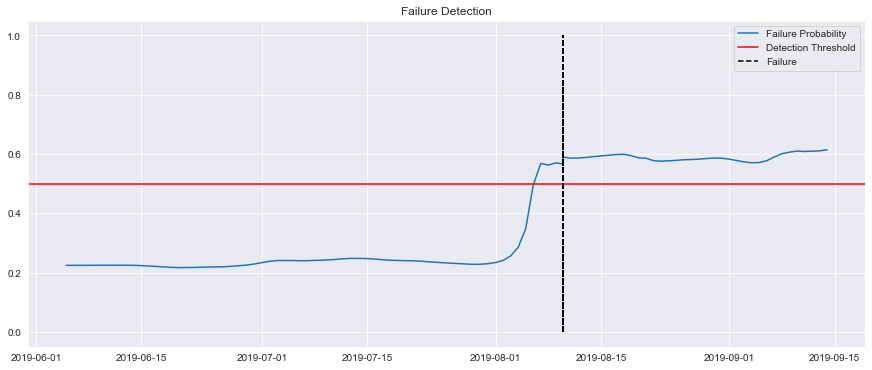

In [25]:
welld, ts = get_well_data(well_id)
plt.figure(figsize=(15,6))
failure_index = welld.iloc[100:300].query("FAILURE == 1").index
#plt.plot(welld.iloc[100:300]['FAILURE'])
plt.title('Failure Detection')
plt.plot(pd.DataFrame(model.predict(ts)[100:300], index=welld.iloc[100:300].index))
#plt.axhline(y=0.55, color='r', linestyle='-')
plt.axhline(y=0.5, color='r', linestyle='-')
plt.vlines(failure_index, ymax=1, ymin=0, color="black", linestyle='--', )
plt.legend(["Failure Probability", "Detection Threshold", "Failure"])
plt.show();

**Saving Model**

We'll save these model components in two files, the architecture in a json file that the keras package can use to rebuild the model, and the weights in an HDF5 heirachy that rebuild the exact model.

In [26]:
import os
import h5py
from sklearn import datasets 
 
LSTM_MODEL = 'modellstm.json'
MODEL_WEIGHTS = 'modellstm.h5'

model_json = model.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODEL_WEIGHTS)
print("Model saved")

Model saved
